In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_scores = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_scores, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date").dropna().set_index("Date")
precip_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


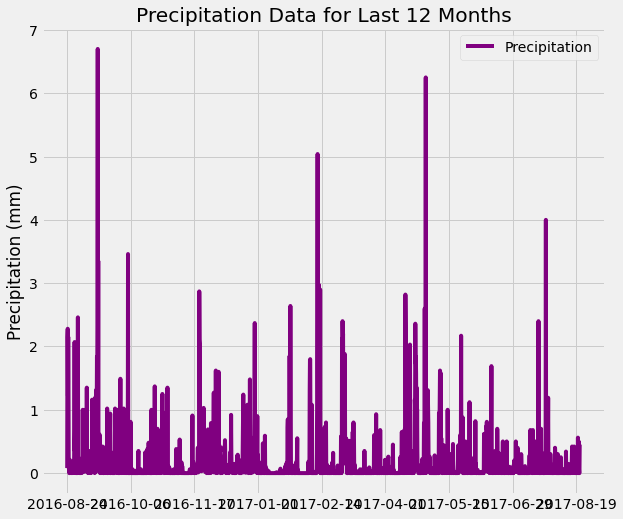

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(color="purple", figsize=(9, 8))
plt.title("Precipitation Data for Last 12 Months")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")
plt.savefig("./images/precip.png")

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Station).count()

stations_count

9

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

session.query(Measurement.station,  func.min(Measurement.tobs), 
    func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).\
    group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date_most_active = session.query(Measurement.date).filter(Measurement.station==most_active).\
    order_by(Measurement.date.desc()).first()[0]

recent_date_most_active = dt.datetime.strptime(recent_date_most_active, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago_most_active = recent_date_most_active - dt.timedelta(days=365)

# Perform a query to retrieve the data and temperatures
temps_most_active = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > one_year_ago)
    .filter(Measurement.station==most_active)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
temps_df_most_active = pd.DataFrame(temps_most_active, columns=["Date", "Temperature"])

# Sort the dataframe by date
temps_df_most_active = temps_df_most_active.sort_values("Date").dropna().set_index("Date")

temps_df_most_active

,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


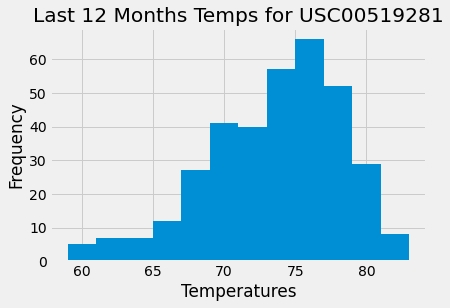

In [25]:
temps_df_most_active.hist(bins=12)
plt.title(f"Last 12 Months Temps for {most_active}")
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.show()

# Close session

In [26]:
# Close Session
session.close()